# Cleaning and trimming of fastq files
Your fastq reads that you received from the sequencing facility will most likely contain all raw reads, including low quality reads. Further, most if not all reads will probably contain parts of the Illumina adapter sequences, which are attached on both ends of the read. In order to prepare the reads for further steps, we need to make sure that we properly clean them and that we clip off all remaining adapter contaminations.

**Note: Please check: Is secapr_env activated??**

The program for cleaning and trimming can be called as follows:

In [32]:
%%bash
source activate secapr_env
secapr clean_reads -h

usage: secapr clean_reads [-h] --input INPUT --config CONFIG --output OUTPUT
                          [--read_min READ_MIN] [--index {single,double}]
                          [--seedMismatches SEEDMISMATCHES]
                          [--palindromeClipThreshold PALINDROMECLIPTHRESHOLD]
                          [--simpleClipThreshold SIMPLECLIPTHRESHOLD]
                          [--windowSize WINDOWSIZE]
                          [--requiredQuality REQUIREDQUALITY]
                          [--leadingQuality LEADINGQUALITY]
                          [--trailingQuality TRAILINGQUALITY]
                          [--cropToLength CROPTOLENGTH] [--headCrop HEADCROP]
                          [--minLength MINLENGTH]

Clean and trim raw Illumina read files

optional arguments:
  -h, --help            show this help message and exit
  --input INPUT         The directory containing the unzipped .fastq or .fq
                        files (raw read files)
  --config CONFIG       A configurati

The script requires a config file which should contain the adapter and barcode information. You see an example of the config file below. The file consists of 3 sections:
- [adapters]

Here you provide the adapter sequences that were used during library preparation in the lab. Check which Illumina kit was used and find the corresponding sequences either in the Illumina manual or on their [webpage](https://support.illumina.com/content/dam/illumina-support/documents/documentation/chemistry_documentation/experiment-design/illumina-adapter-sequences_1000000002694-01.pdf). Add a * in the spot where the sample specific barcode will be inserted.
- [names]

Here you provide a unique string for each sample, as it occurs in the filename (this is how the program recognizes which files to process). You usually have two file for each sample (forward and backward reads). Make sure that this unique identifier occurs in both of those files. Add ':_' after each identifier (don't ask why).
- [barcodes]

Here you specify the sample specific barcode for each sample. First you state which adapter (i7 or i5) the barcode will be inserted in, followed by a dash (-) and the name of the sample, as stated in the section [names].


.

_Note: If you are working with double indexed adapters (both adapters containing barcodes), don't forget to add the * in the position where the barcode is inserted, also for the i5 adapter. In that case make sure in the [barcodes]-section to assign both barcodes for each sample to the correct adapter, e.g.:_

_i7-sampleID:AAACCC_

_i5-sampleID:AATTCC_

In [16]:
%%bash
cat ../../data/raw/adapter_info.txt

[adapters]
i7:GATCGGAAGAGCACACGTCTGAACTCCAGTCAC*ATCTCGTATGCCGTCTTCTGCTTG
i5:AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT

[names]
1061:_
1063:_
1064:_
1065:_
1068:_
1070:_
1073:_
1074:_
1079:_
1080:_
1082:_
1083:_
1085:_
1086:_
1087:_
1140:_
1164:_
1165:_
1166:_
1167:_

[barcodes]
i7-1061:AGTCAA
i7-1063:ATGTCA
i7-1064:CCGTCC
i7-1065:GTAGAG
i7-1068:GTGGCC
i7-1070:CGTACG
i7-1073:ACTGAT
i7-1074:ATGAGC
i7-1079:CACGAT
i7-1080:CACTCA
i7-1082:CATGGC
i7-1083:CATTTT
i7-1085:CGGAAT
i7-1086:CTAGCT
i7-1087:CTATAC
i7-1140:TATAAT
i7-1164:GTGGCC
i7-1165:GTTTCG
i7-1166:CGTACG
i7-1167:GAGTGG


## Cleaning and trimming with default settings

After preparing your config file in the previous step, you are ready to start with cleaning and trimming of your fastq files. For now let's just run the script with default settings. We will show below how to customize the settings of the script in order to achive the best cleaning results for your dataset.
Let's run the script as in this example command:

    secapr clean_reads --input data/raw/fastq/ --config data/raw/adapter_info.txt --output data/processed/cleaned_trimmed_reads_default --index single

### Checking results
Now we want to check if the cleaning and trimming was successful. For this purpose there exists a perfect tool called 'fastqc' which returns reports for every fastq file, summarizing many different parameters concerning read quality.

**Note: Please check: Is secapr_env activated??**

#### 1. Prepare text-file with file-paths

Prepare a file that contains the file paths of all cleaned fastq-files of interest (you can do it manually or use the following commands, after inserting the correct path to your output folder in the bash for-loop [replace `../../data/processed/cleaned_trimmed_reads/*/` with the path to your folder containing the cleaned reads]):

    for dir in ../../data/processed/cleaned_trimmed_reads_default/*/*READ1.fastq; do echo $dir; done > ../../data/processed/fastq_file_list.txt
    
    for dir in ../../data/processed/cleaned_trimmed_reads_default/*/*READ2.fastq; do echo $dir; done >> ../../data/processed/fastq_file_list.txt

After successfully running these for-loops, the resulting file `fastq_file_list.txt` should contain the path to all samples that you want to quality check:

In [1]:
%%bash
head ../../data/processed/fastq_file_list.txt

../../data/processed/cleaned_trimmed_reads/1061_clean/1061_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1063_clean/1063_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1064_clean/1064_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1065_clean/1065_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1068_clean/1068_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1070_clean/1070_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1073_clean/1073_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1074_clean/1074_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1079_clean/1079_clean-READ1.fastq
../../data/processed/cleaned_trimmed_reads/1080_clean/1080_clean-READ1.fastq


#### 2. Run fastqc for quality check

Now run `fastqc` in order to produce a quality check for all these samples. Make sure to create the output directory manually before running the command (otherwise `fastqc` will return an error). 

    mkdir ../../data/processed/fastqc_results
    fastqc -o ../../data/processed/fastqc_results -f fastq $(cat ../../data/processed/fastq_file_list.txt)

You should spend some time going through the quality reports and make sure all samples passed all tests. Most likely there will be some warnings or even some failed tests for some samples. In that case go back to the `clean_reads` function and set the parameters differently, in order to address the problematic test results. Preferably all samples should pass all tests (there may still be some warnings) before you continue to the next step.

We provide an R-script which gives a graphical overview over the test results of all samples. This makes it easier to see if all samples passed the tests (rather than having to go open each individual report):

#### 3. Visualize results

You should spend some time going through the quality reports and make sure all samples passed all tests. Most likely there will be some warnings or even some failed tests for some samples. In that case go back to the clean_reads function and set the parameters differently, in order to address the problematic test results. Preferably all samples should pass all tests (there may still be some warnings) before you continue to the next step.

We provide an R-script which gives a graphical overview over the test results of all samples. This makes it easier to see if all samples passed the tests (rather than having to go open each individual report).

    Rscript ../../src/fastqc_visualization.r -i ../../data/processed/fastqc_results_default/ -o ../../data/processed/fastqc_results_default/summary_all_samples_default.pdf

This is what the quality check results look like for the uncleaned reads: 

Fastqc results of uncleaned fastq-files:


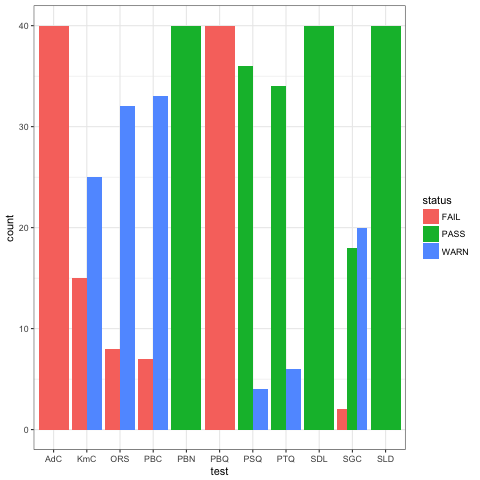

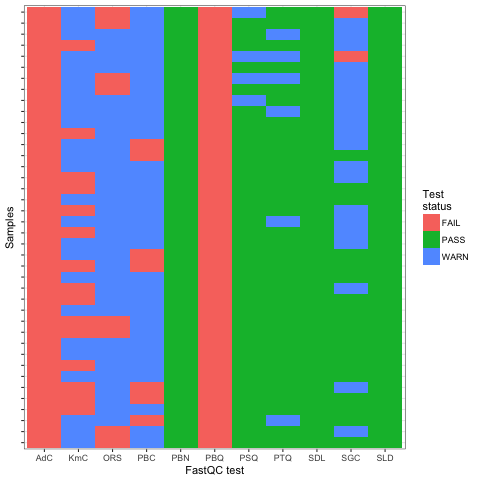

In [28]:
from IPython.display import Image, display
img1 = Image("../../data/raw/fastqc_results/summary_all_samples1.png")
img2 = Image("../../data/raw/fastqc_results/summary_all_samples2.png")
print("Fastqc results of uncleaned fastq-files:")
display(img1,img2)

After running the cleaning and trimming script with default settings we see a definite improve of quality of our fastq-files:

Fastqc results of fastq-files cleaned with default settings:


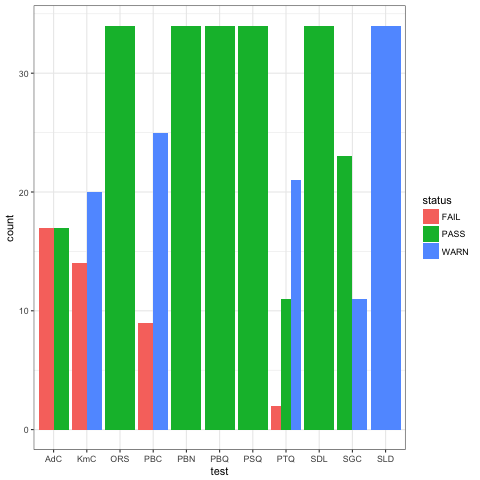

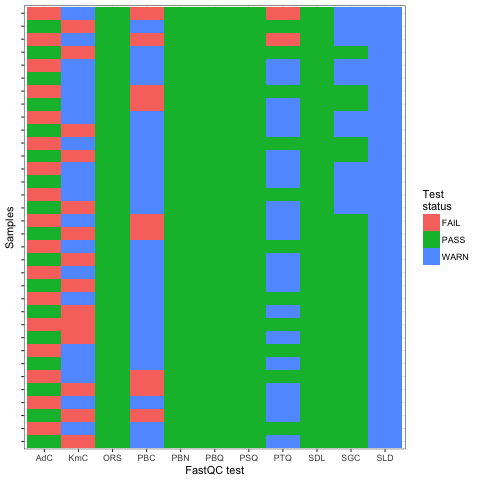

In [30]:
from IPython.display import Image, display
img1 = Image("../../data/processed/fastqc_results_default/summary_all_samples_default1.png")
img2 = Image("../../data/processed/fastqc_results_default/summary_all_samples_default2.png")
print("Fastqc results of fastq-files cleaned with default settings:")
display(img1,img2)

#### 4. Evaluate quality check results and adjust settings of script accordingly

As you can see, running the script with default settings improved the file quality but there is a lot of room for improvement. Running the clean_reads program with the default options leaves many samples failing some of the tests. After reviewing the intial quality reports and after trying a bunch of different flags and values, we ended up with this command for the example data. See the script documentation for more information about the different flags (`secapr clean_reads -h`). You can see how the overall quality of the data improved (compare r-plots to the ones above):

    secapr clean_reads --input data/raw/fastq/ --config data/raw/adapter_info.txt --output data/processed/cleaned_trimmed_reads --index single --simpleClipThreshold 5 --palindromeClipThreshold 20 --seedMismatches 5 --headCrop 10

Fastqc results of properly cleaned fastq-files, using customized settings:


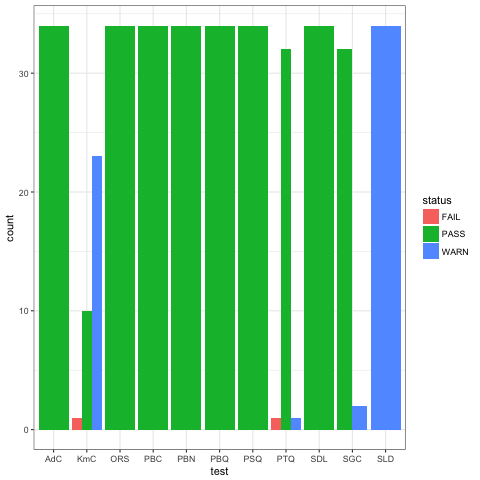

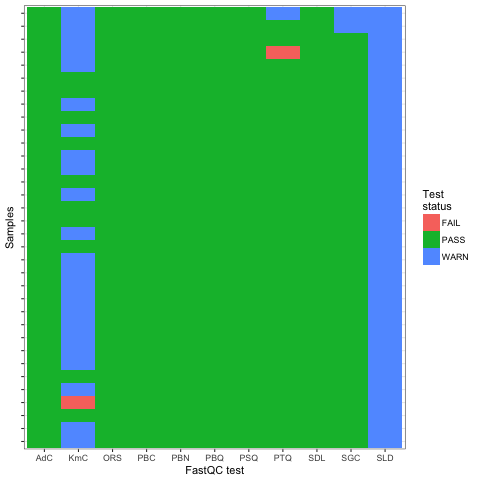

In [31]:
from IPython.display import Image, display
img1 = Image("../../data/processed/fastqc_results/summary_all_samples1.png")
img2 = Image("../../data/processed/fastqc_results/summary_all_samples2.png")
print("Fastqc results of properly cleaned fastq-files, using customized settings:")
display(img1,img2)

Once all samples are properly cleaned, move on to the next step, the [contig assembly](./contig_assembly.ipynb)

[Next page](contig_assembly.ipynb)